# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [2]:
import h2o
import os
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import shap
import pandas as pd

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch 

# init h2o
h2o.init(max_mem_size='12G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month and 5 days
H2O cluster name:,H2O_from_python_ngill_kt4cvs
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [3]:
train_path = os.sep.join(['..', 'data', 'output', 'simu_train.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'simu_test.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (80000, 20)
Test shape: (20000, 19)


In [5]:
train.head()

C1,outcome,outcome_no_noise,fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,intercept,prot_class1,ctrl_class1,prot_class2,ctrl_class2,latent_no_noise,logistic_noise,latent_with_noise,fold
51965,1,0,0.839247,0.81573,0.233273,0.0712949,0.402164,1,1,3,-2.72091,0,1,0,1,-0.0685853,0.19742,0.128834,1
17435,1,1,0.525419,0.820907,0.512061,0.959843,0.623719,1,1,3,-2.72091,0,1,1,0,1.9267,0.897373,2.82408,2
48424,1,1,0.360269,0.75643,0.576162,0.532702,0.0432589,1,1,3,-2.72091,0,1,0,1,0.0715976,0.426443,0.498041,4
33915,1,0,0.229449,0.66919,0.843938,0.0922275,0.0338441,1,1,3,-2.72091,0,1,0,1,-0.951668,2.3566,1.40493,1
99940,0,0,0.674454,0.501915,0.423838,0.158557,0.562246,1,0,2,-2.72091,0,1,0,1,-0.370235,-0.0833795,-0.453614,2
13760,1,0,0.594695,0.485944,0.453524,0.377025,0.142704,1,1,3,-2.72091,0,1,0,1,-0.0891082,2.0873,1.99819,4
87850,0,0,0.554962,0.142204,0.640426,0.98044,0.445186,0,1,2,-2.72091,1,0,1,0,-0.545174,-0.499752,-1.04493,1
80162,0,0,0.21333,0.633964,0.603668,0.36097,0.247929,1,1,0,-2.72091,0,1,0,1,-0.983626,-0.710717,-1.69434,5
58687,0,0,0.368177,0.770775,0.198582,0.114277,0.0220358,1,1,3,-2.72091,0,1,0,1,-0.400844,-0.237349,-0.638193,5
44248,1,1,0.504913,0.78061,0.278483,0.407989,0.974955,1,1,2,-2.72091,0,1,0,1,0.55672,0.0060862,0.562806,3


In [6]:
train.summary()

,C1,outcome,outcome_no_noise,fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,intercept,prot_class1,ctrl_class1,prot_class2,ctrl_class2,latent_no_noise,logistic_noise,latent_with_noise,fold
type,int,int,int,real,real,real,real,real,int,int,int,real,int,int,int,int,real,real,real,int
mins,0.0,0.0,0.0,5.993720636792679e-06,5.8484963424982016e-06,1.0780942417172514e-05,1.2877269565669754e-06,1.1794417957365304e-05,0.0,0.0,0.0,-2.720908013105422,0.0,0.0,0.0,0.0,-3.08207822955209,-6.977000592821803,-7.12822858651175,1.0
mean,49959.918050000015,0.49935,0.5009,0.499772771291759,0.5005156605400479,0.4997349160374042,0.49970378351051314,0.5003267108451944,0.5013875,0.8005,1.8754875,-2.720908013105422,0.14920000000000003,0.8508,0.493275,0.506725,0.0007982856251728507,-0.0006313009765887875,0.00016698464858406296,3.0018749999999987
maxs,99999.0,1.0,1.0,0.9999779765400002,0.9999890264956286,0.9999945142954458,0.9999815918221177,0.9999884430981296,1.0,1.0,4.0,-2.720908013105422,1.0,1.0,1.0,1.0,3.2888372264073396,6.470597632146622,5.904559925891165,5.0
sigma,28895.0686241579,0.500002702526478,0.5000023150235785,0.2882996257422905,0.2886715877500042,0.2882859755442119,0.2888185891874711,0.28884782872641634,0.5000011998573086,0.39962700893686903,1.188339930003665,2.220459916065927e-16,0.35628773029931093,0.35628773029931093,0.4999578970760794,0.49995789707607935,0.9119039514730627,0.9080878617558317,1.2845097123335296,1.4162879501603733
zeros,1,40052,39928,0,0,0,0,0,39889,15960,15969,0,68064,11936,40538,39462,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,51965.0,1.0,0.0,0.8392467973769617,0.8157304958676279,0.2332731763434404,0.07129490031080189,0.4021640971574773,1.0,1.0,3.0,-2.720908013105422,0.0,1.0,0.0,1.0,-0.06858534100749303,0.19741968939352392,0.1288343483860309,1.0
1,17435.0,1.0,1.0,0.5254191073537032,0.820907136047182,0.512060973354806,0.95984262896293,0.6237194690232792,1.0,1.0,3.0,-2.720908013105422,0.0,1.0,1.0,0.0,1.926704951999059,0.8973734832579258,2.8240784352569843,2.0
2,48424.0,1.0,1.0,0.3602693659010231,0.7564304080663468,0.5761618454587174,0.5327017334947878,0.043258948658088416,1.0,1.0,3.0,-2.720908013105422,0.0,1.0,0.0,1.0,0.07159755219096109,0.4264432225168168,0.4980407747077779,4.0


In [7]:
test.head()

C1,outcome,outcome_no_noise,fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,intercept,prot_class1,ctrl_class1,prot_class2,ctrl_class2,latent_no_noise,logistic_noise,latent_with_noise
81101,0,0,0.849904,0.281757,0.885856,0.255401,0.356855,0,1,2,-2.72091,0,1,1,0,-0.691063,0.0320475,-0.659016
23267,0,0,0.0888431,0.833081,0.627163,0.0497448,0.50842,1,1,3,-2.72091,0,1,0,1,-1.43746,-1.79025,-3.22771
55847,1,0,0.126262,0.451901,0.732873,0.5199,0.48319,1,0,2,-2.72091,0,1,1,0,-0.924411,2.92769,2.00328
36104,1,0,0.139916,0.958078,0.0312187,0.142685,0.179793,1,0,3,-2.72091,0,1,0,1,-0.109132,0.141285,0.032153
13217,0,0,0.0162819,0.975709,0.0777005,0.0148265,0.115625,1,1,3,-2.72091,0,1,0,1,-1.61251,-0.00312947,-1.61564
62817,0,0,0.0199051,0.908849,0.848083,0.117873,0.564219,1,1,3,-2.72091,0,1,0,1,-1.17269,-0.344136,-1.51683
69779,1,1,0.342897,0.514568,0.281129,0.656239,0.909317,1,1,0,-2.72091,0,1,0,1,0.645227,0.599765,1.24499
67094,0,0,0.862784,0.255917,0.806889,0.32279,0.0876008,0,1,2,-2.72091,0,1,0,1,-1.13228,0.305278,-0.827003
53829,0,0,0.523056,0.379357,0.207451,0.618397,0.187829,0,0,2,-2.72091,0,1,1,0,-0.286394,-2.48516,-2.77156
20294,1,0,0.155356,0.703031,0.206925,0.585896,0.06441,1,1,3,-2.72091,0,1,0,1,-0.318272,1.16812,0.849848


In [8]:
test.summary()

,C1,outcome,outcome_no_noise,fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,intercept,prot_class1,ctrl_class1,prot_class2,ctrl_class2,latent_no_noise,logistic_noise,latent_with_noise
type,int,int,int,real,real,real,real,real,int,int,int,real,int,int,int,int,real,real,real
mins,2.0,0.0,0.0,5.354501783522957e-06,4.465679264262415e-06,1.120115784735912e-05,1.2345216481953824e-05,5.9251237695870275e-08,0.0,0.0,0.0,-2.720908013105422,0.0,0.0,0.0,0.0,-2.9708160865975466,-6.102900930067954,-8.18129580932468
mean,50157.8278,0.49935,0.49865,0.501443000565748,0.4976173346369308,0.5017576569954016,0.5017269859976042,0.4978021079745367,0.49735,0.8008,1.86995,-2.720908013105422,0.15285,0.84715,0.4958,0.5042,-0.003193142500652193,0.0025252039063551807,-0.0006679385942970072
maxs,99977.0,1.0,1.0,0.9999935013680497,0.9999935603322316,0.9999683397720096,0.9999188775098924,0.9999883388723309,1.0,1.0,4.0,-2.720908013105422,1.0,1.0,1.0,1.0,3.1480336616634506,5.15068621320296,6.735894876511168
sigma,28757.92874371047,0.5000120779580282,0.5000106779198837,0.2898957467069073,0.288680541456105,0.2903051113246434,0.28978469165001103,0.2887294511182761,0.5000054777438829,0.39940873346337624,1.1828385151184595,2.2205015513807916e-16,0.35985184752562877,0.35985184752562877,0.4999948597165646,0.49999485971656465,0.924023667273663,0.9078968103490572,1.2919513385880899
zeros,0,10013,10027,0,0,0,0,0,10053,3984,4001,0,16943,3057,10084,9916,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,81101.0,0.0,0.0,0.8499041678104391,0.28175709898797396,0.8858559099230232,0.2554011590887179,0.35685453705632375,0.0,1.0,2.0,-2.720908013105422,0.0,1.0,1.0,0.0,-0.6910631454449327,0.03204747166047098,-0.6590156737844618
1,23267.0,0.0,0.0,0.0888431184941566,0.8330812813075777,0.6271631716538477,0.049744820036620944,0.508419703971701,1.0,1.0,3.0,-2.720908013105422,0.0,1.0,0.0,1.0,-1.4374551476933446,-1.790254240468232,-3.2277093881615766
2,55847.0,1.0,0.0,0.12626159795934638,0.4519005042300335,0.7328727603071761,0.5199002402193534,0.48319034275008466,1.0,0.0,2.0,-2.720908013105422,0.0,1.0,1.0,0.0,-0.9244111076188346,2.9276933206503815,2.003282213031546


In [22]:
# Inputs and output
X = ["fried" + str(x) for x in range(1, 6)] + ["binary1", "binary2", "cat1"]
fold_column = 'fold'
Y = "outcome"

In [12]:
# Convert outcome to categorical
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

In [13]:
# Distribution of outcome in train
train[Y].table()

outcome,Count
0,40052
1,39948


In [14]:
# Distribution of outcome in test
test[Y].table()

outcome,Count
0,10013
1,9987


In [15]:
# Function to get Shapley contribs
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

In [16]:
# Create Pandas frame for correlation purposes
train_pd_for_corr = train.as_data_frame()

In [17]:
# Get correlation
numeric_corr = pd.DataFrame(train_pd_for_corr[X + [Y]].corr()[Y]).iloc[:-1]
numeric_corr

,outcome
fried1,0.104844
fried2,0.070056
fried3,-0.028836
fried4,0.355040
fried5,0.200641
binary1,0.052379
binary2,-0.023671
cat1,0.051354


In [19]:
# Filter to correlations > 0.1
numeric_corr = numeric_corr[numeric_corr['outcome'].abs() > 0.1]
numeric_corr

,outcome
fried1,0.104844
fried4,0.355040
fried5,0.200641


In [20]:
# Apply monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train_pd_for_corr[list(numeric_corr.index) + [Y]].corr()[Y].values[:-1])])
mono_constraints = dict(zip(list(numeric_corr.index.tolist()), mono_constraints))
#del mono_constraints['loan_amount_conforming']
#del mono_constraints['property_value']
mono_constraints

{'fried1': 1, 'fried4': 1, 'fried5': 1}

In [23]:
# Default GBM with monotonic constraints
mgbm_default = H2OGradientBoostingEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED,
               categorical_encoding="one_hot_explicit")
mgbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [24]:
mgbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1575578788830_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,19574.0,5.0,5.0,5.0,19.0,31.0,26.46




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.16578393924667212
RMSE: 0.40716573928398264
LogLoss: 0.5038175434746567
Mean Per-Class Error: 0.24000079560134457
AUC: 0.8436310851115338
pr_auc: 0.8416411096126658
Gini: 0.6872621702230677

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4172122045363377: 


,,0,1,Error,Rate
0,0,25473.0,14579.0,0.364,(14579.0/40052.0)
1,1,5572.0,34376.0,0.1395,(5572.0/39948.0)
2,Total,31045.0,48955.0,0.2519,(20151.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.417212,0.773337,236.0
1,max f2,0.270644,0.860304,303.0
2,max f0point5,0.575101,0.772417,164.0
3,max accuracy,0.505520,0.760000,195.0
4,max precision,0.977729,1.000000,0.0
5,max recall,0.033774,1.000000,397.0
6,max specificity,0.977729,1.000000,0.0
7,max absolute_mcc,0.505520,0.519999,195.0
8,max min_per_class_accuracy,0.505520,0.759387,195.0
9,max mean_per_class_accuracy,0.505520,0.759999,195.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.93 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.932966,1.990087,1.990087,0.993750,0.948765,0.993750,0.948765,0.019901,0.019901,99.008711,99.008711
1,,2,0.02,0.912459,1.967558,1.978822,0.982500,0.922053,0.988125,0.935409,0.019676,0.039576,96.755783,97.882247
2,,3,0.03,0.896236,1.942525,1.966723,0.970000,0.904237,0.982083,0.925018,0.019425,0.059002,94.252528,96.672341
3,,4,0.04,0.881849,1.927506,1.956919,0.962500,0.888904,0.977187,0.915990,0.019275,0.078277,92.750576,95.691899
4,,5,0.05,0.869173,1.907480,1.947031,0.952500,0.875511,0.972250,0.907894,0.019075,0.097352,90.747972,94.703114
5,,6,0.10,0.817658,1.864924,1.905978,0.931250,0.842701,0.951750,0.875297,0.093246,0.190598,86.492440,90.597777
6,,7,0.15,0.772157,1.784820,1.865592,0.891250,0.794453,0.931583,0.848349,0.089241,0.279839,78.482027,86.559194
7,,8,0.20,0.731114,1.674677,1.817863,0.836250,0.751160,0.907750,0.824052,0.083734,0.363573,67.467708,81.786322
8,,9,0.30,0.652445,1.538250,1.724659,0.768125,0.691182,0.861208,0.779762,0.153825,0.517398,53.824972,72.465872
9,,10,0.40,0.578874,1.318714,1.623173,0.658500,0.615263,0.810531,0.738637,0.131871,0.649269,31.871433,62.317262




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.16852339594376184
RMSE: 0.41051601179949343
LogLoss: 0.5102349157467372
Mean Per-Class Error: 0.24590503057950164
AUC: 0.8366442683038134
pr_auc: 0.833845428564218
Gini: 0.6732885366076269

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4077558771793208: 


,,0,1,Error,Rate
0,0,24661.0,15391.0,0.3843,(15391.0/40052.0)
1,1,5483.0,34465.0,0.1373,(5483.0/39948.0)
2,Total,30144.0,49856.0,0.2609,(20874.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.407756,0.767560,245.0
1,max f2,0.254757,0.857633,314.0
2,max f0point5,0.572475,0.766605,168.0
3,max accuracy,0.507733,0.754100,199.0
4,max precision,0.977648,1.000000,0.0
5,max recall,0.030872,1.000000,398.0
6,max specificity,0.977648,1.000000,0.0
7,max absolute_mcc,0.482269,0.508316,212.0
8,max min_per_class_accuracy,0.503881,0.752946,201.0
9,max mean_per_class_accuracy,0.507733,0.754095,199.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.93 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.932785,1.987584,1.987584,0.992500,0.949798,0.992500,0.949798,0.019876,0.019876,98.758386,98.758386
1,,2,0.02,0.912619,1.955042,1.971313,0.976250,0.922035,0.984375,0.935917,0.019550,0.039426,95.504155,97.131271
2,,3,0.03,0.897288,1.927506,1.956710,0.962500,0.904978,0.977083,0.925604,0.019275,0.058701,92.750576,95.671039
3,,4,0.04,0.882703,1.897467,1.941899,0.947500,0.889957,0.969688,0.916692,0.018975,0.077676,89.746671,94.189947
4,,5,0.05,0.870501,1.930009,1.939521,0.963750,0.876538,0.968500,0.908662,0.019300,0.096976,93.000901,93.952138
5,,6,0.10,0.818871,1.847402,1.893461,0.922500,0.844201,0.945500,0.876431,0.092370,0.189346,84.740162,89.346150
6,,7,0.15,0.773300,1.766296,1.851073,0.882000,0.795711,0.924333,0.849524,0.088315,0.277661,76.629619,85.107306
7,,8,0.20,0.731139,1.650646,1.800966,0.824250,0.752218,0.899312,0.825198,0.082532,0.360193,65.064584,80.096626
8,,9,0.30,0.652308,1.522229,1.708054,0.760125,0.691470,0.852917,0.780622,0.152223,0.512416,52.222890,70.805380
9,,10,0.40,0.578383,1.314709,1.609718,0.656500,0.614793,0.803813,0.739165,0.131471,0.643887,31.470912,60.971763




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.74192435,0.010106442,0.75267744,0.7352081,0.75321156,0.7330362,0.7354883
1,auc,0.8366619,0.0036433956,0.839276,0.8354781,0.8415619,0.83285826,0.8341352
2,err,0.25807565,0.010106442,0.24732254,0.26479188,0.24678841,0.26696378,0.2645117
3,err_count,4129.4,168.95059,3972.0,4256.0,3919.0,4253.0,4247.0
4,f0point5,0.7235582,0.014747651,0.74156886,0.71310663,0.73770493,0.7121359,0.7132745
5,f1,0.76864564,0.006153018,0.7739328,0.76460177,0.77663153,0.7646505,0.7634115
6,f2,0.81998307,0.006408949,0.8092506,0.82411295,0.8198951,0.82552695,0.82112986
7,lift_top_group,1.9878098,0.027345125,1.9592743,2.0212526,1.9597864,1.997657,2.0010786
8,logloss,0.5102282,0.003486807,0.5081802,0.51128364,0.50520796,0.5130894,0.51337993
9,max_per_class_error,0.37381464,0.03245615,0.33169067,0.39601034,0.34661758,0.40432176,0.39043286



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-05 12:50:59,12.759 sec,0.0,0.500000,0.693146,0.500000,0.000000,1.000000,0.500650
1,,2019-12-05 12:50:59,12.823 sec,1.0,0.491100,0.675482,0.745872,0.699706,1.866242,0.329713
2,,2019-12-05 12:51:00,12.921 sec,2.0,0.483281,0.660126,0.760304,0.743532,1.951305,0.348675
3,,2019-12-05 12:51:00,12.963 sec,3.0,0.477033,0.647881,0.761134,0.752784,1.965609,0.342150
4,,2019-12-05 12:51:00,12.995 sec,4.0,0.471347,0.636731,0.766160,0.758181,1.965380,0.337200
5,,2019-12-05 12:51:00,13.031 sec,5.0,0.467398,0.628938,0.769768,0.762592,1.964729,0.326113
6,,2019-12-05 12:51:00,13.068 sec,6.0,0.463010,0.620265,0.774889,0.771630,1.972226,0.335875
7,,2019-12-05 12:51:00,13.107 sec,7.0,0.459049,0.612413,0.780581,0.777810,1.977571,0.325487
8,,2019-12-05 12:51:00,13.147 sec,8.0,0.455495,0.605292,0.784385,0.780021,1.977571,0.322012
9,,2019-12-05 12:51:00,13.185 sec,9.0,0.452626,0.599421,0.785602,0.780383,1.977571,0.314350



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,fried4,13312.190430,1.000000,0.343255
1,cat1,6909.442871,0.519031,0.178160
2,fried1,6232.358887,0.468169,0.160702
3,fried2,5485.864258,0.412093,0.141453
4,fried5,3392.475586,0.254840,0.087475
5,fried3,2722.592529,0.204519,0.070202
6,binary1,409.783508,0.030783,0.010566
7,binary2,317.463562,0.023848,0.008186


In [25]:
# Get the AUC on the test set for MGBM
perf_mgbm_default = mgbm_default.model_performance(test)
print(perf_mgbm_default.auc())

0.8401602698708561


In [26]:
# Get the AUC on 5 fold CV for MGBM
perf_cv_mgbm_default = mgbm_default.model_performance(xval=True)
print(perf_cv_mgbm_default.auc())

0.8366442683038134


In [27]:
# Default GBM
gbm_default = H2OGradientBoostingEstimator(
               seed=SEED,
               categorical_encoding="one_hot_explicit")
gbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [28]:
gbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1575578788830_471


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,23000.0,5.0,5.0,5.0,30.0,32.0,31.94




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.15922169530617397
RMSE: 0.39902593312487095
LogLoss: 0.4865477417404558
Mean Per-Class Error: 0.23075309122272425
AUC: 0.8517381513124757
pr_auc: 0.8498434313949876
Gini: 0.7034763026249513

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4149766088255354: 


,,0,1,Error,Rate
0,0,26779.0,13273.0,0.3314,(13273.0/40052.0)
1,1,5953.0,33995.0,0.149,(5953.0/39948.0)
2,Total,32732.0,47268.0,0.2403,(19226.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.414977,0.779559,237.0
1,max f2,0.245545,0.862672,311.0
2,max f0point5,0.592581,0.781711,161.0
3,max accuracy,0.496054,0.769238,204.0
4,max precision,0.969106,1.000000,0.0
5,max recall,0.037551,1.000000,398.0
6,max specificity,0.969106,1.000000,0.0
7,max absolute_mcc,0.496054,0.538544,204.0
8,max min_per_class_accuracy,0.503087,0.768401,201.0
9,max mean_per_class_accuracy,0.496054,0.769247,204.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.93 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.939102,1.985081,1.985081,0.991250,0.949036,0.991250,0.949036,0.019851,0.019851,98.508060,98.508060
1,,2,0.02,0.925337,1.975068,1.980074,0.986250,0.932122,0.988750,0.940579,0.019751,0.039601,97.506759,98.007410
2,,3,0.03,0.914336,1.975068,1.978405,0.986250,0.919675,0.987917,0.933611,0.019751,0.059352,97.506759,97.840526
3,,4,0.04,0.904348,1.940022,1.968809,0.968750,0.909258,0.983125,0.927522,0.019400,0.078752,94.002203,96.880945
4,,5,0.05,0.895391,1.914989,1.958045,0.956250,0.899800,0.977750,0.921978,0.019150,0.097902,91.498949,95.804546
5,,6,0.10,0.853227,1.880945,1.919495,0.939250,0.874133,0.958500,0.898055,0.094047,0.191950,88.094523,91.949534
6,,7,0.15,0.811676,1.796836,1.878609,0.897250,0.832326,0.938083,0.876146,0.089842,0.281791,79.683589,87.860886
7,,8,0.20,0.769938,1.677681,1.828377,0.837750,0.790679,0.913000,0.854779,0.083884,0.365675,67.768099,82.837689
8,,9,0.30,0.683649,1.561780,1.739511,0.779875,0.726752,0.868625,0.812103,0.156178,0.521853,56.178031,73.951136
9,,10,0.40,0.595182,1.352508,1.642761,0.675375,0.639518,0.820312,0.768957,0.135251,0.657104,35.250826,64.276059




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.16425711324504566
RMSE: 0.4052864582552021
LogLoss: 0.4984449128545991
Mean Per-Class Error: 0.24004914193304994
AUC: 0.8406322078559313
pr_auc: 0.8379369016662515
Gini: 0.6812644157118626

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3998110254310271: 


,,0,1,Error,Rate
0,0,25521.0,14531.0,0.3628,(14531.0/40052.0)
1,1,5764.0,34184.0,0.1443,(5764.0/39948.0)
2,Total,31285.0,48715.0,0.2537,(20295.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.399811,0.771100,243.0
1,max f2,0.214485,0.858691,323.0
2,max f0point5,0.583596,0.769284,165.0
3,max accuracy,0.493759,0.759938,203.0
4,max precision,0.969214,1.000000,0.0
5,max recall,0.032021,1.000000,399.0
6,max specificity,0.969214,1.000000,0.0
7,max absolute_mcc,0.493759,0.520004,203.0
8,max min_per_class_accuracy,0.503135,0.758639,199.0
9,max mean_per_class_accuracy,0.493759,0.759951,203.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.94 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.939305,1.985081,1.985081,0.991250,0.949830,0.991250,0.949830,0.019851,0.019851,98.508060,98.508060
1,,2,0.02,0.925496,1.965055,1.975068,0.981250,0.931964,0.986250,0.940897,0.019651,0.039501,96.505457,97.506759
2,,3,0.03,0.914632,1.937519,1.962551,0.967500,0.919870,0.980000,0.933888,0.019375,0.058877,93.751877,96.255132
3,,4,0.04,0.904626,1.925003,1.953164,0.961250,0.909740,0.975313,0.927851,0.019250,0.078127,92.500250,95.316411
4,,5,0.05,0.895433,1.904976,1.943527,0.951250,0.900068,0.970500,0.922295,0.019050,0.097176,90.497647,94.352658
5,,6,0.10,0.853361,1.860419,1.901973,0.929000,0.874189,0.949750,0.898242,0.093021,0.190197,86.041854,90.197256
6,,7,0.15,0.811068,1.753780,1.852575,0.875750,0.832169,0.925083,0.876218,0.087689,0.277886,75.377991,85.257501
7,,8,0.20,0.768562,1.669170,1.806724,0.833500,0.789749,0.902188,0.854600,0.083458,0.361345,66.916992,80.672374
8,,9,0.30,0.682819,1.532242,1.715230,0.765125,0.725836,0.856500,0.811679,0.153224,0.514569,53.224191,71.522980
9,,10,0.40,0.593926,1.317463,1.615788,0.657875,0.638974,0.806844,0.768503,0.131746,0.646315,31.746270,61.578802




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7469443,0.007760329,0.75155663,0.73943883,0.75824934,0.7425146,0.7429621
1,auc,0.84067535,0.003529589,0.84362715,0.8391561,0.84520394,0.8371774,0.8382122
2,err,0.2530557,0.007760329,0.24844334,0.2605612,0.24175063,0.25748542,0.25703788
3,err_count,4049.2,137.65428,3990.0,4188.0,3839.0,4102.0,4127.0
4,f0point5,0.7286087,0.011605195,0.7376196,0.71753085,0.7442045,0.72166353,0.72202516
5,f1,0.77167594,0.0057041016,0.77674574,0.7668151,0.77854055,0.7702218,0.76605636
6,f2,0.82028306,0.004374151,0.8202553,0.823369,0.81619817,0.8257862,0.8158066
7,lift_top_group,1.9877298,0.02255447,1.9715197,2.0212526,1.9722692,1.9725292,2.0010786
8,logloss,0.49843848,0.0037153915,0.49550742,0.50034493,0.49344897,0.5015175,0.5013737
9,max_per_class_error,0.36195317,0.023020754,0.351908,0.38443542,0.32821423,0.38121408,0.3639941



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-05 12:51:30,11.653 sec,0.0,0.500000,0.693146,0.500000,0.000000,1.000000,0.500650
1,,2019-12-05 12:51:30,11.671 sec,1.0,0.489341,0.672028,0.770356,0.679416,1.852185,0.311163
2,,2019-12-05 12:51:30,11.685 sec,2.0,0.480464,0.654657,0.781403,0.693012,1.858579,0.306575
3,,2019-12-05 12:51:30,11.701 sec,3.0,0.472677,0.639513,0.789959,0.758777,1.947421,0.301350
4,,2019-12-05 12:51:30,11.721 sec,4.0,0.465707,0.625982,0.797185,0.767017,1.954044,0.299600
5,,2019-12-05 12:51:30,11.747 sec,5.0,0.459743,0.614383,0.802440,0.776964,1.964092,0.289725
6,,2019-12-05 12:51:30,11.780 sec,6.0,0.454571,0.604271,0.805949,0.786653,1.969619,0.281662
7,,2019-12-05 12:51:30,11.813 sec,7.0,0.449987,0.595222,0.808279,0.789513,1.973963,0.291100
8,,2019-12-05 12:51:30,11.849 sec,8.0,0.445787,0.586875,0.810859,0.801776,1.980407,0.282363
9,,2019-12-05 12:51:30,11.885 sec,9.0,0.442174,0.579633,0.813236,0.804773,1.976929,0.282300



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,fried4,14270.337891,1.000000,0.364494
1,cat1,6444.775879,0.451620,0.164613
2,fried1,5732.654297,0.401718,0.146424
3,fried2,5537.400879,0.388036,0.141437
4,fried5,3523.985840,0.246945,0.090010
5,fried3,3091.931641,0.216668,0.078974
6,binary2,322.123291,0.022573,0.008228
7,binary1,227.897278,0.015970,0.005821


In [29]:
# Get the AUC on the test set for the default GBM
perf_gbm_default = gbm_default.model_performance(test)
print(perf_gbm_default.auc())

0.844748142624361


In [30]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_gbm_default = gbm_default.model_performance(xval=True)
print(perf_cv_gbm_default.auc())

0.8406322078559313


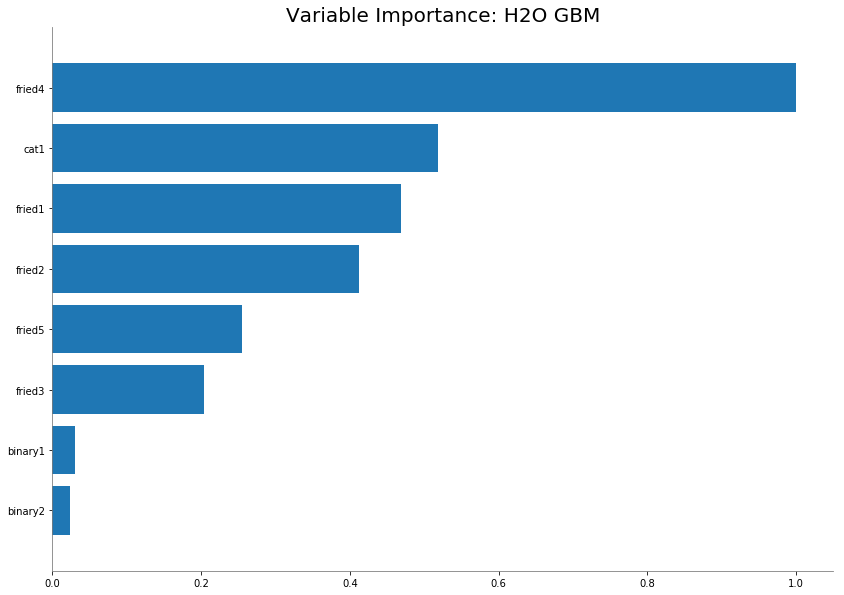

In [33]:
# MGBM var importance
mgbm_default.varimp_plot()

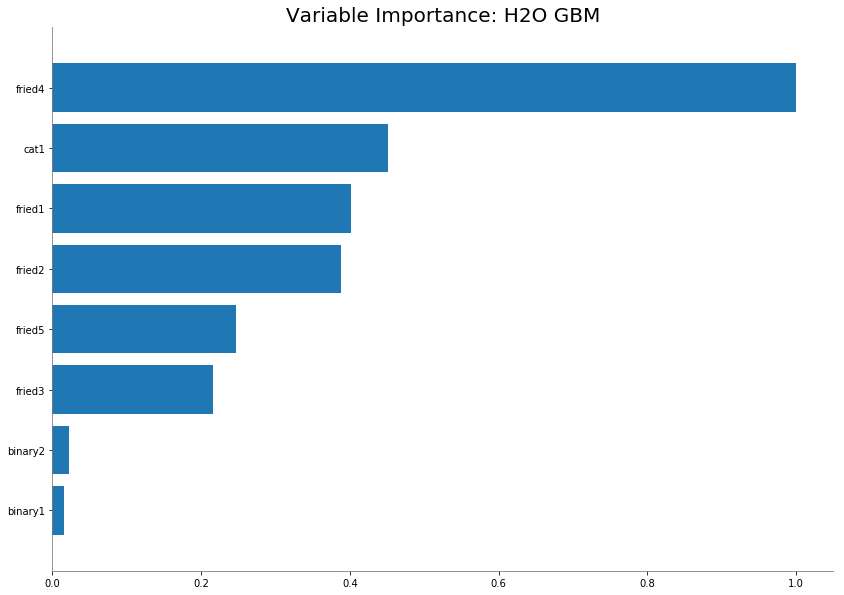

In [34]:
# GBM var importance
gbm_default.varimp_plot()

## Shapley for MGBM

In [35]:
shap_values_mgbm_default, expected_value_mgbm_default = get_shapley(mgbm_default, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.599066,0.451934,-0.0464876,-1.11644,-0.123579,0.0588323,-0.041759,0.34306,-0.00621184
0.40088,0.442138,-0.27334,1.15782,0.285269,0.0968728,-0.0417837,0.450948,-0.00621184
0.119242,0.447313,-0.199363,0.161063,-0.457515,0.0769993,-0.0433234,0.375944,-0.00621184
-0.236174,0.304504,0.00196113,-1.13074,-0.463997,0.0512873,-0.0355486,0.35785,-0.00621184
0.64429,0.289482,-0.219238,-1.04104,0.153692,0.0466682,0.172689,-0.554558,-0.00621184


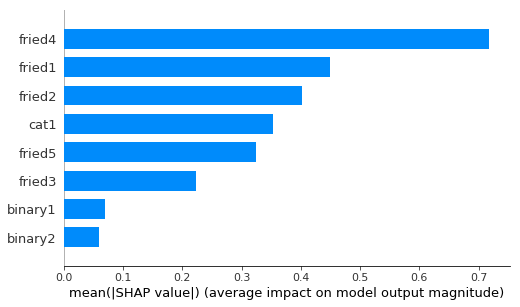

In [36]:
shap.summary_plot(shap_values_mgbm_default, X, plot_type="bar")

## Shapley for GBM

In [37]:
shap_values_gbm_default, expected_value_gbm_default = get_shapley(gbm_default, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.724602,0.550852,-0.0984897,-1.19361,-0.0960698,0.0419696,-0.061961,0.374188,-0.00467028
0.393449,0.727396,-0.300681,1.24876,0.222565,0.0756877,-0.0412661,0.391257,-0.00467028
0.130395,0.583664,-0.330525,0.137158,-0.515531,0.112987,-0.0668423,0.426591,-0.00467028
-0.383588,0.338184,-0.0101796,-1.30299,-0.490338,0.0491815,-0.08413,0.292361,-0.00467028
0.674954,0.385993,-0.286857,-1.09823,0.12537,0.070345,0.129547,-0.655237,-0.00467028


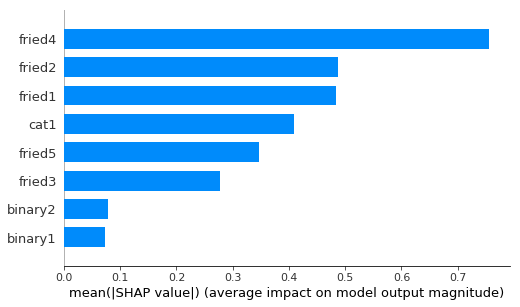

In [38]:
shap.summary_plot(shap_values_gbm_default, X, plot_type="bar")

In [39]:
# Default XGBoost with monotonic constraints
mxgb_default = H2OXGBoostEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED)
mxgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [40]:
mxgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1575578788830_1014


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14978238768982718
RMSE: 0.3870172963703653
LogLoss: 0.45799046674528343
Mean Per-Class Error: 0.21836509153700479
AUC: 0.8652685126162863
pr_auc: 0.8599193189795798
Gini: 0.7305370252325727

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40233101866331444: 


,,0,1,Error,Rate
0,0,27440.0,12612.0,0.3149,(12612.0/40052.0)
1,1,5511.0,34437.0,0.138,(5511.0/39948.0)
2,Total,32951.0,47049.0,0.2265,(18123.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.402331,0.791682,238.0
1,max f2,0.206370,0.867689,312.0
2,max f0point5,0.614335,0.795111,158.0
3,max accuracy,0.515786,0.781650,195.0
4,max precision,0.996657,1.000000,0.0
5,max recall,0.003774,1.000000,399.0
6,max specificity,0.996657,1.000000,0.0
7,max absolute_mcc,0.518267,0.563451,194.0
8,max min_per_class_accuracy,0.503210,0.780765,200.0
9,max mean_per_class_accuracy,0.515786,0.781635,195.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.94 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.987331,1.992590,1.992590,0.995000,0.992239,0.995000,0.992239,0.019926,0.019926,99.259037,99.259037
1,,2,0.02,0.978592,1.975068,1.983829,0.986250,0.982889,0.990625,0.987564,0.019751,0.039677,97.506759,98.382898
2,,3,0.03,0.971009,1.972564,1.980074,0.985000,0.974741,0.988750,0.983290,0.019726,0.059402,97.256433,98.007410
3,,4,0.04,0.963115,1.950035,1.972564,0.973750,0.967055,0.985000,0.979231,0.019500,0.078903,95.003505,97.256433
4,,5,0.05,0.954796,1.952538,1.968559,0.975000,0.958992,0.983000,0.975183,0.019525,0.098428,95.253830,96.855913
5,,6,0.10,0.915103,1.898468,1.933514,0.948000,0.935240,0.965500,0.955212,0.094923,0.193351,89.846801,93.351357
6,,7,0.15,0.870836,1.823871,1.896966,0.910750,0.893705,0.947250,0.934710,0.091194,0.284545,82.387103,89.696606
7,,8,0.20,0.823579,1.745770,1.859167,0.871750,0.847508,0.928375,0.912909,0.087288,0.371833,74.576950,85.916692
8,,9,0.30,0.721556,1.583308,1.767214,0.790625,0.773019,0.882458,0.866279,0.158331,0.530164,58.330830,76.721404
9,,10,0.40,0.613205,1.382798,1.671110,0.690500,0.667724,0.834469,0.816640,0.138280,0.668444,38.279764,67.110994




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.1621148273476811
RMSE: 0.40263485610125843
LogLoss: 0.49077321682993025
Mean Per-Class Error: 0.23893573880139862
AUC: 0.8421669288871098
pr_auc: 0.8367524595154349
Gini: 0.6843338577742195

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4009829729290332: 


,,0,1,Error,Rate
0,0,26533.0,13519.0,0.3375,(13519.0/40052.0)
1,1,6249.0,33699.0,0.1564,(6249.0/39948.0)
2,Total,32782.0,47218.0,0.2471,(19768.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.400983,0.773214,236.0
1,max f2,0.171645,0.858979,328.0
2,max f0point5,0.618980,0.771882,152.0
3,max accuracy,0.511660,0.761075,193.0
4,max precision,0.997031,1.000000,0.0
5,max recall,0.004217,1.000000,399.0
6,max specificity,0.997031,1.000000,0.0
7,max absolute_mcc,0.511660,0.522205,193.0
8,max min_per_class_accuracy,0.501638,0.759438,197.0
9,max mean_per_class_accuracy,0.511660,0.761064,193.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.94 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.987394,1.982577,1.982577,0.990000,0.992380,0.990000,0.992380,0.019826,0.019826,98.257735,98.257735
1,,2,0.02,0.979176,1.960048,1.971313,0.978750,0.983184,0.984375,0.987782,0.019600,0.039426,96.004806,97.131271
2,,3,0.03,0.971223,1.927506,1.956710,0.962500,0.975011,0.977083,0.983525,0.019275,0.058701,92.750576,95.671039
3,,4,0.04,0.963081,1.932512,1.950661,0.965000,0.967157,0.974063,0.979433,0.019325,0.078026,93.251227,95.066086
4,,5,0.05,0.955244,1.925003,1.945529,0.961250,0.959096,0.971500,0.975366,0.019250,0.097276,92.500250,94.552919
5,,6,0.10,0.914863,1.858917,1.902223,0.928250,0.935616,0.949875,0.955491,0.092946,0.190222,85.891659,90.222289
6,,7,0.15,0.870621,1.765295,1.856580,0.881500,0.893335,0.927083,0.934772,0.088265,0.278487,76.529488,85.658022
7,,8,0.20,0.823225,1.684189,1.813483,0.841000,0.846917,0.905563,0.912809,0.084209,0.362697,68.418945,81.348253
8,,9,0.30,0.721322,1.532743,1.719903,0.765375,0.772719,0.858833,0.866112,0.153274,0.515971,53.274257,71.990254
9,,10,0.40,0.612720,1.326224,1.621483,0.662250,0.667208,0.809688,0.816386,0.132622,0.648593,32.622409,62.148293




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.752643,0.0061461846,0.7600249,0.7521309,0.75554156,0.75224406,0.74327356
1,auc,0.84217197,0.0033311702,0.84519607,0.8396225,0.8463801,0.840016,0.8396451
2,err,0.24735701,0.0061461846,0.2399751,0.2478691,0.24445844,0.24775594,0.25672644
3,err_count,3957.8,105.21977,3854.0,3984.0,3882.0,3947.0,4122.0
4,f0point5,0.7358924,0.0102028325,0.7496794,0.7340885,0.73940086,0.734883,0.7214104
5,f1,0.7734537,0.0051997807,0.77870923,0.7698174,0.77913064,0.7718629,0.7677485
6,f2,0.81517243,0.00637338,0.8100779,0.8092022,0.82337236,0.8127617,0.820448
7,lift_top_group,1.9828317,0.02876048,1.9470289,2.0212526,1.9722692,1.9725292,2.0010786
8,logloss,0.49076363,0.00506024,0.48603687,0.49520954,0.4845201,0.49386674,0.49418485
9,max_per_class_error,0.33997262,0.020502938,0.31450593,0.33173254,0.34623682,0.33712217,0.3702656



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-05 12:53:27,21.721 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.500650
1,,2019-12-05 12:53:27,21.925 sec,1.0,0.472482,0.638931,0.760702,0.701164,1.904973,0.319962
2,,2019-12-05 12:53:28,22.070 sec,2.0,0.456435,0.607042,0.778566,0.752963,1.952787,0.318263
3,,2019-12-05 12:53:28,22.209 sec,3.0,0.445057,0.583799,0.791520,0.784492,1.960681,0.306737
4,,2019-12-05 12:53:28,22.365 sec,4.0,0.437081,0.566879,0.800427,0.796781,1.977225,0.299862
5,,2019-12-05 12:53:28,22.527 sec,5.0,0.430194,0.552648,0.812670,0.809457,1.984419,0.283450
6,,2019-12-05 12:53:28,22.688 sec,6.0,0.423108,0.537816,0.822389,0.819048,1.973837,0.278062
7,,2019-12-05 12:53:28,22.845 sec,7.0,0.417432,0.525980,0.831284,0.828730,1.985955,0.267788
8,,2019-12-05 12:53:29,23.002 sec,8.0,0.414232,0.519017,0.834805,0.832391,1.987584,0.264663
9,,2019-12-05 12:53:29,23.157 sec,9.0,0.410289,0.510626,0.839779,0.837133,1.990134,0.257925



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,fried4,21794.289062,1.000000,0.293506
1,cat1,12974.041016,0.595295,0.174723
2,fried2,12169.335938,0.558373,0.163886
3,fried1,11881.926758,0.545185,0.160015
4,fried3,7591.890625,0.348343,0.102241
5,fried5,6338.607422,0.290838,0.085363
6,binary2,892.461426,0.040949,0.012019
7,binary1,612.341675,0.028096,0.008246


In [41]:
# Get the AUC on the test set for MXGB
perf_mxgb_default = mxgb_default.model_performance(test)
print(perf_mxgb_default.auc())

0.8450385181150956


In [42]:
# Get the AUC on 5 fold CV for the default MXGB
perf_cv_mxgb_default = mxgb_default.model_performance(xval=True)
print(perf_cv_mxgb_default.auc())

0.8421669288871098


In [43]:
# Default XGBoost
xgb_default = H2OXGBoostEstimator(
               seed=SEED)
xgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [44]:
xgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1575578788830_1258


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14584176589142042
RMSE: 0.3818923485635977
LogLoss: 0.4479397764985198
Mean Per-Class Error: 0.21103309539593118
AUC: 0.8723379161260784
pr_auc: 0.8694913749176679
Gini: 0.7446758322521567

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40047381642986746: 


,,0,1,Error,Rate
0,0,27759.0,12293.0,0.3069,(12293.0/40052.0)
1,1,5429.0,34519.0,0.1359,(5429.0/39948.0)
2,Total,33188.0,46812.0,0.2215,(17722.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.400474,0.795735,236.0
1,max f2,0.209640,0.871387,311.0
2,max f0point5,0.613481,0.802368,154.0
3,max accuracy,0.497944,0.788963,198.0
4,max precision,0.994910,1.000000,0.0
5,max recall,0.011590,1.000000,398.0
6,max specificity,0.994910,1.000000,0.0
7,max absolute_mcc,0.497944,0.577944,198.0
8,max min_per_class_accuracy,0.501047,0.787526,197.0
9,max mean_per_class_accuracy,0.497944,0.788967,198.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.93 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.982252,1.997597,1.997597,0.997500,0.988136,0.997500,0.988136,0.019976,0.019976,99.759688,99.759688
1,,2,0.02,0.973253,1.990087,1.993842,0.993750,0.977653,0.995625,0.982894,0.019901,0.039877,99.008711,99.384199
2,,3,0.03,0.965726,1.977571,1.988418,0.987500,0.969605,0.992917,0.978465,0.019776,0.059653,97.757084,98.841828
3,,4,0.04,0.957777,1.965055,1.982577,0.981250,0.961654,0.990000,0.974262,0.019651,0.079303,96.505457,98.257735
4,,5,0.05,0.950434,1.945029,1.975068,0.971250,0.954250,0.986250,0.970260,0.019450,0.098753,94.502854,97.506759
5,,6,0.10,0.913695,1.920997,1.948032,0.959250,0.932069,0.972750,0.951164,0.096050,0.194803,92.099730,94.803244
6,,7,0.15,0.873136,1.824872,1.906979,0.911250,0.893428,0.952250,0.931919,0.091244,0.286047,82.487233,90.697907
7,,8,0.20,0.828264,1.753279,1.868554,0.875500,0.850751,0.933063,0.911627,0.087664,0.373711,75.327926,86.855412
8,,9,0.30,0.730208,1.611345,1.782818,0.804625,0.779761,0.890250,0.867671,0.161134,0.534845,61.134475,78.281766
9,,10,0.40,0.620407,1.393562,1.685504,0.695875,0.676249,0.841656,0.819816,0.139356,0.674201,39.356163,68.550365




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.16339743170099863
RMSE: 0.40422448181796045
LogLoss: 0.4939959938518674
Mean Per-Class Error: 0.24094673094997532
AUC: 0.8397980045711276
pr_auc: 0.8352735237585077
Gini: 0.6795960091422553

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36171199359330053: 


,,0,1,Error,Rate
0,0,25011.0,15041.0,0.3755,(15041.0/40052.0)
1,1,5455.0,34493.0,0.1366,(5455.0/39948.0)
2,Total,30466.0,49534.0,0.2562,(20496.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.361712,0.770948,252.0
1,max f2,0.182638,0.858327,321.0
2,max f0point5,0.593173,0.769628,164.0
3,max accuracy,0.513232,0.759062,197.0
4,max precision,0.994975,1.000000,0.0
5,max recall,0.005614,1.000000,399.0
6,max specificity,0.994975,1.000000,0.0
7,max absolute_mcc,0.513232,0.518163,197.0
8,max min_per_class_accuracy,0.505557,0.758261,200.0
9,max mean_per_class_accuracy,0.513232,0.759053,197.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.93 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.981770,1.985081,1.985081,0.991250,0.987817,0.991250,0.987817,0.019851,0.019851,98.508060,98.508060
1,,2,0.02,0.972918,1.962551,1.973816,0.980000,0.977314,0.985625,0.982565,0.019626,0.039476,96.255132,97.381596
2,,3,0.03,0.964956,1.925003,1.957545,0.961250,0.968946,0.977500,0.978026,0.019250,0.058726,92.500250,95.754481
3,,4,0.04,0.956933,1.930009,1.950661,0.963750,0.960995,0.974063,0.973768,0.019300,0.078026,93.000901,95.066086
4,,5,0.05,0.949447,1.925003,1.945529,0.961250,0.953123,0.971500,0.969639,0.019250,0.097276,92.500250,94.552919
5,,6,0.10,0.911628,1.847902,1.896716,0.922750,0.931099,0.947125,0.950369,0.092395,0.189672,84.790227,89.671573
6,,7,0.15,0.870616,1.762291,1.851907,0.880000,0.891460,0.924750,0.930733,0.088115,0.277786,76.229098,85.190748
7,,8,0.20,0.825775,1.671673,1.806849,0.834750,0.848568,0.902250,0.910192,0.083584,0.361370,67.167318,80.684890
8,,9,0.30,0.727556,1.521228,1.711642,0.759625,0.777277,0.854708,0.865887,0.152123,0.513493,52.122760,71.164180
9,,10,0.40,0.618601,1.330980,1.616476,0.664625,0.673749,0.807187,0.817852,0.133098,0.646591,33.098027,61.647642




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.74631876,0.0044136005,0.74694896,0.74858457,0.75214106,0.74245185,0.74146736
1,auc,0.83980674,0.0034549872,0.8423464,0.837491,0.8445407,0.83811325,0.8365423
2,err,0.25368124,0.0044136005,0.25305107,0.25141543,0.24785894,0.25754818,0.25853264
3,err_count,4059.0,80.433205,4064.0,4041.0,3936.0,4103.0,4151.0
4,f0point5,0.7276847,0.0061127045,0.73052955,0.7310135,0.73448,0.72127956,0.72112083
5,f1,0.7713855,0.0063991114,0.7769974,0.76642966,0.77872723,0.77069247,0.7640807
6,f2,0.82074696,0.011069156,0.82977825,0.8054523,0.8286473,0.8273735,0.8124834
7,lift_top_group,1.9852664,0.020230932,1.9592743,2.0086982,1.9847519,1.9725292,2.0010786
8,logloss,0.49398467,0.004781277,0.49037367,0.49764353,0.48747197,0.4962944,0.49813983
9,max_per_class_error,0.3646458,0.019142568,0.37882233,0.33481097,0.36311716,0.38383713,0.36264142



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-05 12:54:12,17.329 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.500650
1,,2019-12-05 12:54:12,17.476 sec,1.0,0.467369,0.629199,0.788398,0.722584,1.905627,0.307538
2,,2019-12-05 12:54:12,17.569 sec,2.0,0.447500,0.590362,0.807833,0.776180,1.952329,0.281237
3,,2019-12-05 12:54:12,17.668 sec,3.0,0.434260,0.563674,0.818517,0.794453,1.975999,0.269137
4,,2019-12-05 12:54:12,17.786 sec,4.0,0.424621,0.543752,0.827732,0.817263,1.985734,0.271050
5,,2019-12-05 12:54:12,17.898 sec,5.0,0.418189,0.529860,0.832989,0.825865,1.985146,0.264263
6,,2019-12-05 12:54:13,18.009 sec,6.0,0.412765,0.518054,0.838280,0.833550,1.990149,0.253063
7,,2019-12-05 12:54:13,18.121 sec,7.0,0.409097,0.509712,0.841574,0.837817,1.995094,0.250900
8,,2019-12-05 12:54:13,18.234 sec,8.0,0.405957,0.502713,0.844958,0.841904,1.992690,0.246337
9,,2019-12-05 12:54:13,18.353 sec,9.0,0.403416,0.496855,0.847285,0.844051,1.992615,0.241962



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,fried4,25116.566406,1.000000,0.328324
1,fried1,12263.756836,0.488274,0.160312
2,cat1,11311.695312,0.450368,0.147867
3,fried2,11185.676758,0.445351,0.146219
4,fried5,7625.186523,0.303592,0.099677
5,fried3,7338.274414,0.292169,0.095926
6,binary1,918.740906,0.036579,0.012010
7,binary2,739.339966,0.029436,0.009665


In [45]:
# Get the AUC on the test set for the default GBM
perf_xgb_default = xgb_default.model_performance(test)
print(perf_xgb_default.auc())

0.844698787540951


In [46]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_xgb_default = xgb_default.model_performance(xval=True)
print(perf_cv_xgb_default.auc())

0.8397980045711276


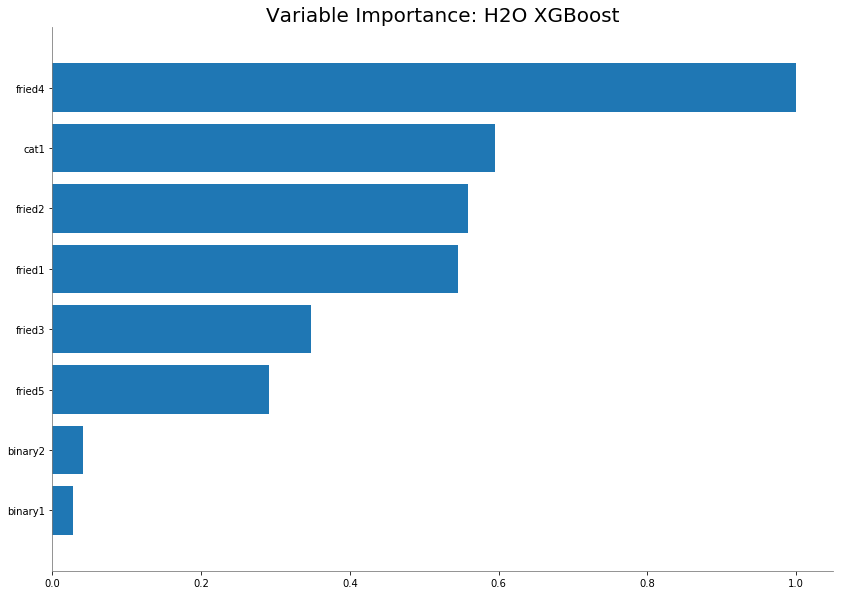

In [47]:
# MXGB var importance
mxgb_default.varimp_plot()

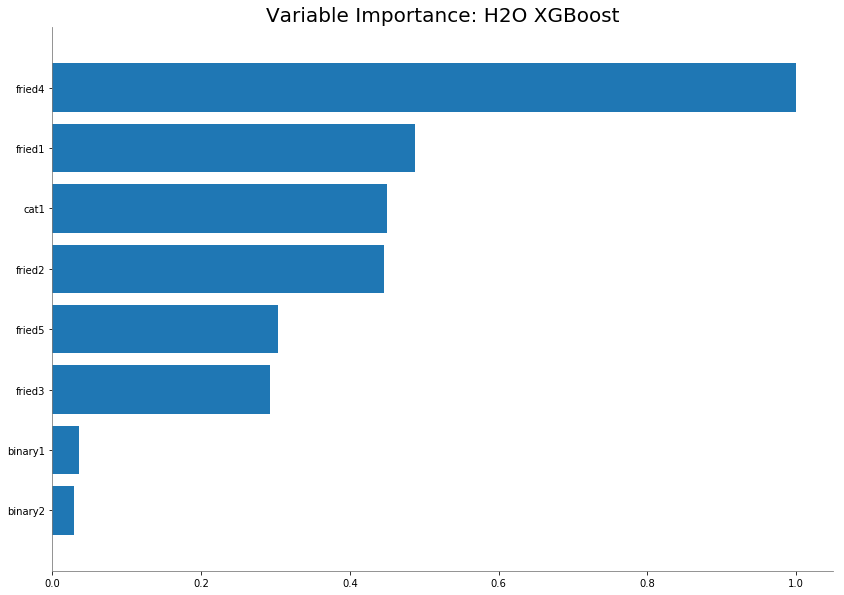

In [48]:
# XGB var importance
xgb_default.varimp_plot()

## Shapey for MXGB

In [49]:
shap_values_mxgb_default, expected_value_mxgb_default = get_shapley(mxgb_default, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
1.1777,0.707241,-0.0751146,-1.50933,-0.163341,0.138074,-0.115383,0.458424,-0.00426159
0.703687,0.970384,-0.614616,1.9521,0.366094,0.214031,-0.112336,0.490003,-0.00426159
0.013586,0.714442,-0.532004,0.214473,-0.760093,0.186018,-0.10869,0.513509,-0.00426159
-0.507414,0.668815,0.209215,-1.61734,-0.782322,0.186095,-0.110665,0.521115,-0.00426159
1.00603,0.306918,-0.508466,-1.3782,0.159902,0.114968,0.337401,-0.960088,-0.00426159


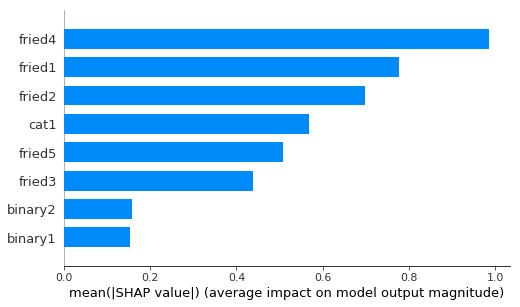

In [50]:
shap.summary_plot(shap_values_mxgb_default, X, plot_type="bar")

## Shapley for XGB

In [51]:
shap_values_xgb_default, expected_value_xgb_default = get_shapley(xgb_default, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.902312,0.573332,-0.0969674,-1.58687,-0.175358,0.105772,-0.120922,0.452739,-0.00351065
0.696363,1.03461,-0.549585,1.7332,0.289875,0.111293,-0.092864,0.541309,-0.00351065
0.0943925,0.646066,-0.512035,0.0721785,-0.788431,0.236511,-0.104125,0.515054,-0.00351065
-0.520693,0.404359,0.477851,-1.35002,-0.537374,0.102356,-0.140091,0.582602,-0.00351065
0.920095,0.42917,-0.421785,-1.26091,0.161365,0.136484,0.271413,-0.911849,-0.00351065


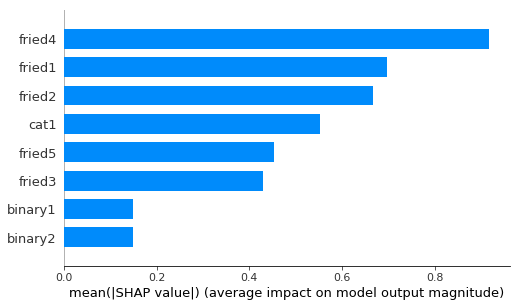

In [52]:
shap.summary_plot(shap_values_xgb_default, X, plot_type="bar")

# MGBM Grid Search (Constrained)

In [56]:
# GBM hyperparameters
hyper_params = {'learn_rate': [i * 0.01 for i in range(1, 11)],
                'max_depth': list(range(2, 11)),
                'sample_rate': [i * 0.1 for i in range(5, 11)],
                'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 36, 'seed': 1}

In [57]:
# Train and validate a random grid of GBMs
mgbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='mgbm_grid2_simulated',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
mgbm_grid2.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [58]:
# Get the grid results, sorted by validation AUC
mgbm_gridperf2 = mgbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [59]:
print(mgbm_gridperf2)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     0.5        0.1         8  0.7000000000000001   
1      0.7000000000000001       0.09        10                 0.5   
2                     0.8       0.09        10  0.7000000000000001   
3                     1.0       0.09        10                 0.9   
4      0.7000000000000001       0.08         9  0.6000000000000001   
5                     1.0       0.09         5                 0.5   
6                     0.9       0.08         6                 0.8   
7     0.30000000000000004        0.1         6  0.7000000000000001   
8     0.30000000000000004       0.08         6                 0.8   
9                     0.4       0.08         5                 0.8   
10                    0.1        0.1        10                 0.5   
11                    0.9       0.06         6                 0.9   
12                    0.4       0.07         5                 0.5   
13                  

In [60]:
# Grab the top GBM model, chosen by validation AUC
best_mgbm2 = mgbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_mgbm_perf2 = best_mgbm2.model_performance(test)

best_mgbm_perf2.auc()

0.8455370839576718

In [61]:
shap_values_mgbm, expected_value_mgbm = get_shapley(best_mgbm2, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.741037,0.429627,-0.064377,-1.16917,-0.0948652,0.107678,-0.0688574,0.315121,0.00243002
0.482348,0.562765,-0.30705,1.30594,0.286075,0.203313,-0.0786212,0.575498,0.00243002
0.102758,0.489965,-0.256617,0.157506,-0.49187,0.108423,-0.0617261,0.42116,0.00243002
-0.403179,0.246301,0.0722072,-1.17063,-0.538253,0.0854749,-0.0747515,0.344605,0.00243002
0.705623,0.300134,-0.24067,-0.947536,0.0974236,0.120937,0.202018,-0.631626,0.00243002


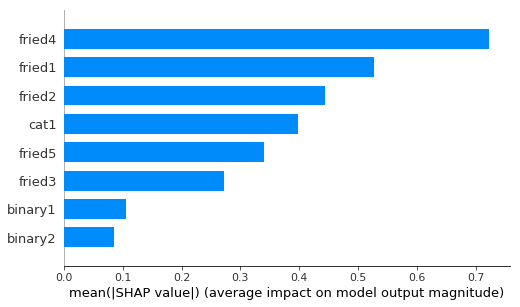

In [62]:
shap.summary_plot(shap_values_mgbm, X, plot_type="bar")

In [64]:
# Save the model
model_path = h2o.save_model(model=best_mgbm2, path="../models/MGBM_BEST_GRID_v2_SIMULATED_" + str(time.time()), 
                            force=True)

print(model_path)

/Users/ngill/Desktop/article-information-2019/models/MGBM_BEST_GRID_v2_SIMULATED_1575579885.932527/mgbm_grid2_simulated_model_20


# GBM Grid Search (Unconstrained)

In [65]:
# Train and validate a random grid of GBMs
gbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution='bernoulli',
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='gbm_grid2_simulated',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
gbm_grid2.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [66]:
# Get the grid results, sorted by validation AUC
gbm_gridperf2 = gbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [67]:
print(gbm_gridperf2)

          col_sample_rate learn_rate max_depth         sample_rate  \
0     0.30000000000000004        0.1         6  0.7000000000000001   
1                     1.0       0.09         5                 0.5   
2                     0.9       0.08         6                 0.8   
3     0.30000000000000004       0.08         6                 0.8   
4                     0.5        0.1         8  0.7000000000000001   
5                     0.4       0.04         9                 0.5   
6      0.7000000000000001       0.08         9  0.6000000000000001   
7                     0.9       0.06         6                 0.9   
8     0.30000000000000004       0.04        10                 0.9   
9                     0.4       0.08         5                 0.8   
10                    0.1        0.1        10                 0.5   
11     0.7000000000000001       0.04         8                 1.0   
12                    0.8       0.05        10  0.6000000000000001   
13                  

In [68]:
# Grab the top GBM model, chosen by validation AUC
best_gbm2 = gbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf2 = best_gbm2.model_performance(test)

best_gbm_perf2.auc()

0.8464419604869132

In [69]:
shap_values_gbm, expected_value_gbm = get_shapley(best_gbm2, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.712444,0.484033,-0.0292182,-1.0783,-0.0689788,0.144068,-0.0628931,0.387311,-0.00447395
0.387904,0.635555,-0.217367,1.29547,0.280237,0.230333,-0.0468988,0.464236,-0.00447395
0.0394849,0.552142,-0.291235,0.196625,-0.577763,0.145431,-0.0816981,0.448272,-0.00447395
-0.405597,0.342999,0.199578,-1.13792,-0.527172,0.117731,-0.100027,0.347015,-0.00447395
0.579179,0.282835,-0.314487,-1.05021,0.101845,0.153361,0.195643,-0.683167,-0.00447395


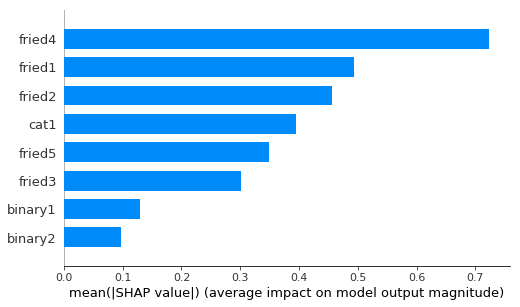

In [70]:
shap.summary_plot(shap_values_gbm, X, plot_type="bar")

In [71]:
# Save the model
model_path = h2o.save_model(model=best_gbm2, path="../models/GBM_BEST_GRID_v2_SIMULATED_" + str(time.time()), 
                            force=True)

print(model_path)

/Users/ngill/Desktop/article-information-2019/models/GBM_BEST_GRID_v2_SIMULATED_1575580421.104081/gbm_grid2_simulated_model_12


# Repeat Previous but with XGBoost

In [72]:
# Train and validate a random grid of XGBoost models
mxgb_grid = H2OGridSearch(model=H2OXGBoostEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    # learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='mxgb_grid2_simulated',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
mxgb_grid.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [73]:
# Get the grid results, sorted by validation AUC
mxgb_gridperf = mxgb_grid.get_grid(sort_by='auc', decreasing=True)

In [74]:
print(mxgb_gridperf)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     1.0       0.09         5                 0.5   
1     0.30000000000000004        0.1         6  0.7000000000000001   
2                     0.9       0.08         6                 0.8   
3                     0.5        0.1         8  0.7000000000000001   
4     0.30000000000000004       0.08         6                 0.8   
5                     0.4       0.08         5                 0.8   
6      0.7000000000000001       0.08         9  0.6000000000000001   
7                     0.8       0.05        10  0.6000000000000001   
8                     0.9       0.06         6                 0.9   
9      0.7000000000000001       0.09        10                 0.5   
10                    0.4       0.07         5                 0.5   
11                    0.8       0.09        10  0.7000000000000001   
12                    1.0       0.09        10                 0.9   
13                  

In [75]:
# Grab the top GBM model, chosen by validation AUC
best_mxgb = mxgb_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_mxgb_perf = best_mxgb.model_performance(test)

best_mxgb_perf.auc()

0.8480489532027309

In [76]:
shap_values_mxgb, expected_value_mxgb = get_shapley(best_mxgb, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
1.01125,0.617973,-0.0611087,-1.39059,-0.132008,0.0911668,-0.0848712,0.4146,-0.00729074
0.574738,0.877768,-0.480022,1.70936,0.343115,0.125212,-0.0715719,0.499437,-0.00729074
0.105621,0.687408,-0.454607,0.198798,-0.676015,0.141354,-0.0812464,0.480229,-0.00729074
-0.448359,0.549114,0.163881,-1.47718,-0.739664,0.116186,-0.0806852,0.431157,-0.00729074
0.888507,0.34228,-0.422503,-1.30316,0.136987,0.102175,0.233699,-0.855973,-0.00729074


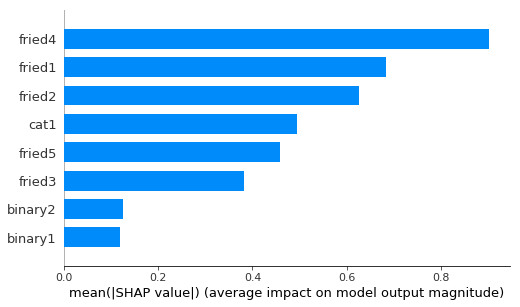

In [77]:
shap.summary_plot(shap_values_mxgb, X, plot_type="bar")

In [78]:
# Save the model
model_path = h2o.save_model(model=best_mxgb, path="../models/MXGB_BEST_GRID_v2_SIMULATED_" + str(time.time()), 
                            force=True)

print(model_path)

/Users/ngill/Desktop/article-information-2019/models/MXGB_BEST_GRID_v2_SIMULATED_1575581571.93721/mxgb_grid2_simulated_model_24


In [79]:
# Train and validate a random grid of XGBoost models
xgb_grid = H2OGridSearch(model=H2OXGBoostEstimator(distribution='bernoulli',
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    # learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='xgb_grid2_simulated',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
xgb_grid.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [80]:
# Get the grid results, sorted by validation AUC
xgb_gridperf = xgb_grid.get_grid(sort_by='auc', decreasing=True)

In [81]:
print(xgb_gridperf)

          col_sample_rate learn_rate max_depth         sample_rate  \
0     0.30000000000000004        0.1         6  0.7000000000000001   
1                     1.0       0.09         5                 0.5   
2     0.30000000000000004       0.08         6                 0.8   
3                     0.4       0.08         5                 0.8   
4                     0.4       0.07         5                 0.5   
5                     0.9       0.08         6                 0.8   
6                     0.9       0.06         6                 0.9   
7                     0.1        0.1        10                 0.5   
8      0.6000000000000001       0.04         7                 0.8   
9                     0.2       0.09         6                 1.0   
10                    0.4       0.04         9                 0.5   
11     0.7000000000000001        0.1         3  0.7000000000000001   
12    0.30000000000000004       0.04        10                 0.9   
13                  

In [82]:
# Grab the top GBM model, chosen by validation AUC
best_xgb = xgb_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_xgb_perf = best_xgb.model_performance(test)

best_xgb_perf.auc()

0.8479293880006656

In [83]:
shap_values_xgb, expected_value_xgb = get_shapley(best_xgb, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.834954,0.536292,-0.0730752,-1.38815,-0.166371,0.197734,-0.11587,0.391173,-0.0039107
0.546965,0.798178,-0.445719,1.65518,0.279889,0.269006,-0.0815599,0.496218,-0.0039107
0.0900415,0.663228,-0.460331,0.191393,-0.748418,0.224469,-0.103007,0.457897,-0.0039107
-0.52698,0.384212,0.276196,-1.45104,-0.665456,0.202386,-0.122363,0.447932,-0.0039107
0.825788,0.343195,-0.422713,-1.22039,0.207144,0.197551,0.329571,-0.813615,-0.0039107


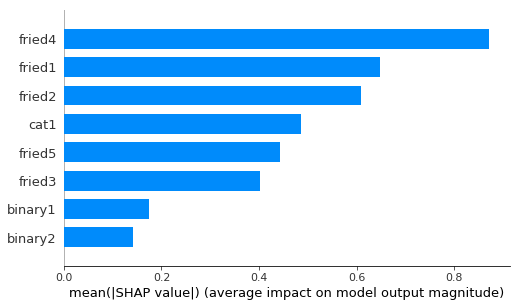

In [84]:
shap.summary_plot(shap_values_xgb, X, plot_type="bar")

In [85]:
# Save the model
model_path = h2o.save_model(model=best_xgb, path="../models/XGB_BEST_GRID_v2_SIMULATED_" + str(time.time()), 
                            force=True)

print(model_path)

/Users/ngill/Desktop/article-information-2019/models/XGB_BEST_GRID_v2_SIMULATED_1575582547.0131981/xgb_grid2_simulated_model_12
